In [112]:
from datasets import list_datasets
import tensorflow as tf

In [3]:
all_datasets = list_datasets()
print(all_datasets[0:5])

['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus']


In [4]:
from datasets import load_dataset

In [6]:
emotions = load_dataset('emotion')

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
import pandas as pd

In [10]:
emotions.set_format(type = 'pandas')

In [12]:
df = emotions['train'][:]
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [13]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


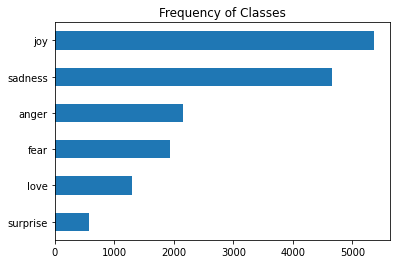

In [16]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

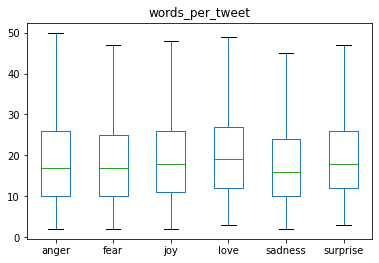

In [23]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot('words_per_tweet', by='label_name', grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [27]:
emotions.reset_format()

In [114]:
from transformers import AutoTokenizer

model_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [118]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [119]:
print(tokenize(emotions['train'][0:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [120]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [122]:
from transformers import TFAutoModelForSequenceClassification

num_labels = 6

tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
tf_model

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_77']
You should probably TRAIN this model on a down-stream task to be able to use i

In [123]:
from sklearn.metrics import accuracy_score, f1_score

In [125]:
tokenizer_columns = tokenizer.model_input_names

In [126]:
batch_size = 64

In [127]:
tf_train_dataset = emotions_encoded['train'].to_tf_dataset(columns = tokenizer_columns, 
                                                           label_cols = ['label'], 
                                                           shuffle=True, batch_size=batch_size)

tf_validation_dataset = emotions_encoded['validation'].to_tf_dataset(columns = tokenizer_columns, 
                                                           label_cols = ['label'], 
                                                           shuffle=True, batch_size=batch_size)

In [129]:
tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics = tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data = tf_validation_dataset, epochs = 2)

Epoch 1/2
250/250 [==============================] - 325s 1s/step - loss: 0.5171 - sparse_categorical_accuracy: 0.8195 - val_loss: 0.1853 - val_sparse_categorical_accuracy: 0.9255
Epoch 2/2
250/250 [==============================] - 308s 1s/step - loss: 0.1365 - sparse_categorical_accuracy: 0.9394 - val_loss: 0.1316 - val_sparse_categorical_accuracy: 0.9325
